# Moving From Regression to Classification

Previously, we've created several regression models to predict the final grade for our students.

We saw that once we removed G1 and G2 grades, it became much more difficult to predict their final score.

Since we cannot trust our models' predictions, we cannot trust the insights/explanations we extract from the model.

Our stakeholder's goal is to identify at-risk students
before their final grade in order to intervene and provide additional support to those students. The stakeholder never said that they need to know the EXACT GRADE for each student.


In this situation, it makes perfect sense to convert this task into a classification that better addresses our stakeholder business case.

# Functions

In [26]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [27]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

In [28]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

In [29]:
# function to get coefficients
def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

In [30]:
# function to plot
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False,  intercept_name = "intercept",annotate=False, ha='left',va='center', size=12, xytext=(4,0), textcoords='offset points'):
  """Plots the top_n coefficients from a Series, with optional annotations."""
# Drop intercept if intercept=False and 
  if (intercept==False) & ( intercept_name in coeffs.index):
    coeffs = coeffs.drop(intercept_name)
  if top_n==None:
    ## sort all features and set title
    plot_vals = coeffs#.sort_values()
    title = "All Coefficients - Ranked by Magnitude"
  else:
    ## rank the coeffs and select the top_n
    coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
    top_n_features = coeff_rank.head(top_n)
## sort features and keep top_n and set title
    plot_vals = coeffs.loc[top_n_features.index].sort_values()
    title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    ## annotating bar values 
  if annotate==True:
    annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
    return ax

In [38]:
def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None, ax=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

# Import 

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set text displays for sklearn
from sklearn import set_config
set_config(display='text')
## Using pd.set_option to display more columns
pd.set_option('display.max_columns',50)


# Plot Styles

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.2}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'



# Preprocessing

In [4]:
## Load in the student performance - Portuguese dataset & display the head and info
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"
df = pd.read_excel(url,sheet_name='student-por')
df.info()
df.head(3)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12


After talking with our stakeholder, we've agreed that predicting which students will receive an F would be the most effective target.

# Calculating Letter Grades from G3

In [5]:
## convert G3 to a % out of 100
df['G3(%)'] = (df['G3']/20) *100
df['G3(%)'].head()



0    55.0
1    55.0
2    60.0
3    70.0
4    65.0
Name: G3(%), dtype: float64

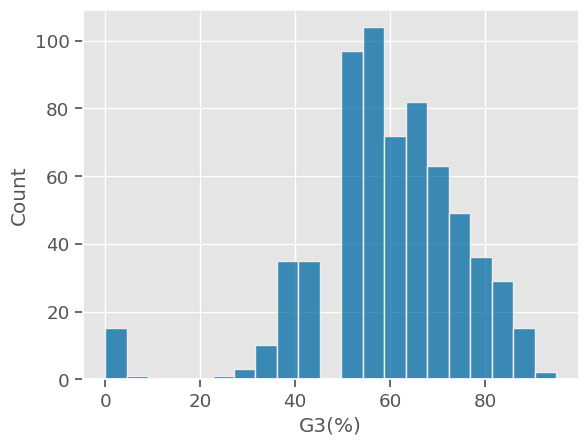

In [6]:
## visual distribution of % grades
ax = sns.histplot(data=df, x='G3(%)')



In [7]:
## defining bin edges
bins = [0,60,70,80,90,100]
grades = pd.cut(df['G3(%)'], bins=bins)
grades.value_counts().sort_index()



(0, 60]      358
(60, 70]     145
(70, 80]      85
(80, 90]      44
(90, 100]      2
Name: G3(%), dtype: int64

But we want to include 0 in the bin and DON'T want to include 60. We want the logic to be 0<=x<60 

In [10]:
gbins = [0,60,70,80,90,101]
grades = pd.cut(df['G3(%)'], bins=bins,right=False)
grades.value_counts()




[0, 60)      301
[60, 70)     154
[70, 80)     112
[80, 90)      65
[90, 100)     17
Name: G3(%), dtype: int64

In [11]:
## defining bins and their labels
bins = [0,60,70,80,90,101]
bin_labels = ['F','D','C','B','A']
grades = pd.cut(df['G3(%)'],bins, labels=bin_labels,include_lowest=True)
grades.value_counts()

F    373
D    145
C     85
B     44
A      2
Name: G3(%), dtype: int64

In [12]:
# add these values to our DataFrame as a new column 'FinalGrade'.
df['FinalGrade'] = pd.cut(df['G3(%)'],bins, labels=bin_labels,include_lowest=True)
df



,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,G3(%),FinalGrade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11,55.0,F
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11,55.0,F
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12,60.0,F
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14,70.0,D
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13,65.0,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,course,mother,1,3,1,no,no,no,yes,no,yes,yes,no,5,4,2,1,2,5,4,10,11,10,50.0,F
645,MS,F,18,U,LE3,T,3,1,teacher,services,course,mother,1,2,0,no,yes,no,no,yes,yes,yes,no,4,3,4,1,1,1,4,15,15,16,80.0,C
646,MS,F,18,U,GT3,T,1,1,other,other,course,mother,2,2,0,no,no,no,yes,yes,yes,no,no,1,1,1,1,1,5,6,11,12,9,45.0,F
647,MS,M,17,U,LE3,T,3,1,services,services,course,mother,2,1,0,no,no,no,no,no,yes,yes,no,2,4,5,3,4,2,6,10,10,10,50.0,F


In [13]:
## We can group by the letter grades and get the min/max of the scores to confirm 
df.groupby('FinalGrade')['G3(%)'].agg(['min','max','count'])



,min,max,count
FinalGrade,,,
F,0.0,60.0,373
D,65.0,70.0,145
C,75.0,80.0,85
B,85.0,90.0,44
A,95.0,95.0,2


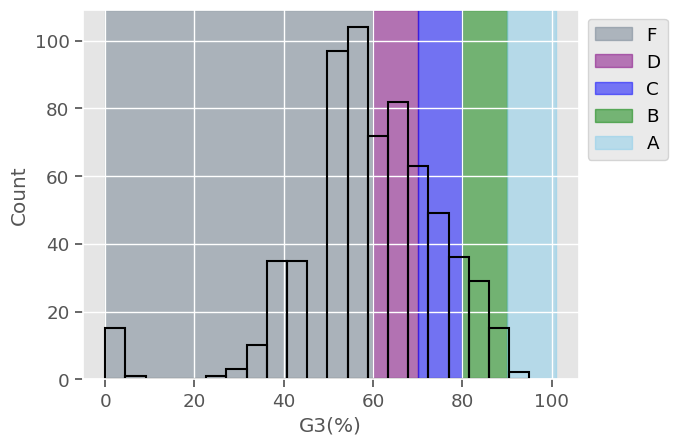

In [14]:
## visualizing the cutoffs for grades
ax = sns.histplot(data=df, x='G3(%)',color='k',fill=False)
colors = ['slategray','purple','blue','green','skyblue']
for i in range(len(bins)-1):
    x1 = bins[i]
    x2 = bins[i+1]
    label = bin_labels[i]
    ax.axvspan(x1,x2, label=label,color=colors[i],zorder=0,alpha=.5)
ax.legend(bbox_to_anchor=[1,1])



We can also view these distributions on two separate graphs.

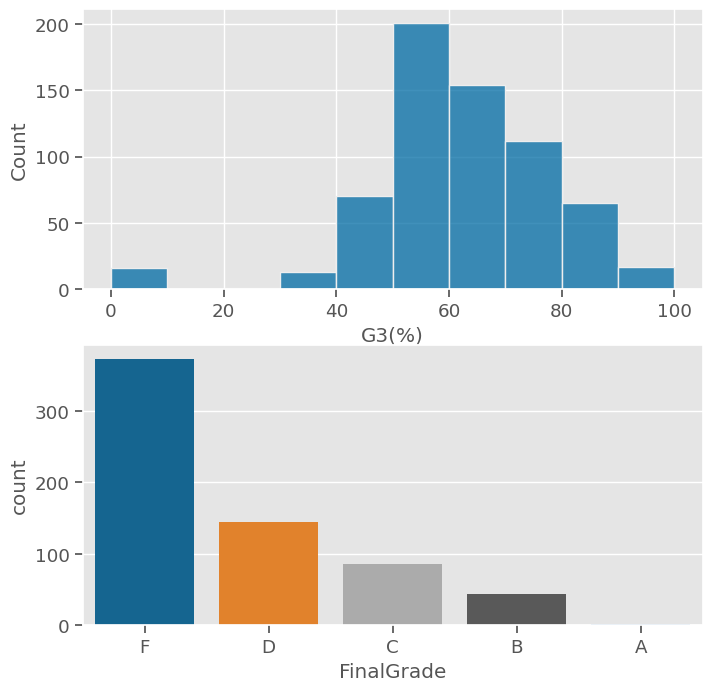

In [15]:
fig, axes = plt.subplots(nrows=2,figsize=(8,8))
sns.histplot(data=df, x='G3(%)',ax=axes[0], binwidth=10);
sns.countplot(data=df,x='FinalGrade',ax=axes[1],order=['F','D','C','B','A']);


# Making Our Final Target & X/y Data

Since we are interested in creating a binary classification. We will define a new column that simply indicates whether a student received an F (failed) or not (passed). We will also check the class balance by using value_counts(normalize=True).

In [16]:
## Define target as had a F or Above
df['target_F'] = df['FinalGrade'] == 'F'
df['target_F'].value_counts(normalize=True)



True     0.57473
False    0.42527
Name: target_F, dtype: float64

In [21]:
## Make x and y variables
drop_feats = ['G1','G2','G3','G3(%)','FinalGrade']
y = df['target_F'].copy()
X = df.drop(columns=['target_F',*drop_feats]).copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)


In [22]:
## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                     fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),                                      verbose_feature_names_out=False)
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)



,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
104,15.0,3.0,4.0,1.0,2.0,0.0,5.0,4.0,4.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
284,18.0,2.0,1.0,1.0,1.0,2.0,3.0,2.0,5.0,2.0,5.0,5.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
579,18.0,1.0,3.0,1.0,1.0,0.0,4.0,3.0,3.0,2.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


# RandomForestClassifier

## Function for Evaluating Classification Models

In [23]:
def evaluate_classification(model, X_train,y_train,X_test,y_test,
                            normalize='true',cmap='Blues', figsize=(10,5)):
    header="\tCLASSIFICATION REPORT"
    dashes='--'*40
    print(f"{dashes}\n{header}\n{dashes}")
    ## training data
    print('[i] Training Data:')
    y_pred_train = model.predict(X_train)
    report_train = metrics.classification_report(y_train, y_pred_train)
    print(report_train)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_train,y_train,
                                                  normalize=normalize,
                                                   cmap=cmap,ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_train,y_train,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    
    fig.tight_layout()
    plt.show()
     
    print(dashes)
    ## test data
    print(f"[i] Test Data:")
    y_pred_test = model.predict(X_test)
    report_test = metrics.classification_report(y_test, y_pred_test)
    print(report_test)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,
                                                  normalize=normalize,
                                                   cmap=cmap, ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    fig.tight_layout()
    plt.show()



--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       205
        True       1.00      1.00      1.00       281

    accuracy                           1.00       486
   macro avg       1.00      1.00      1.00       486
weighted avg       1.00      1.00      1.00       486



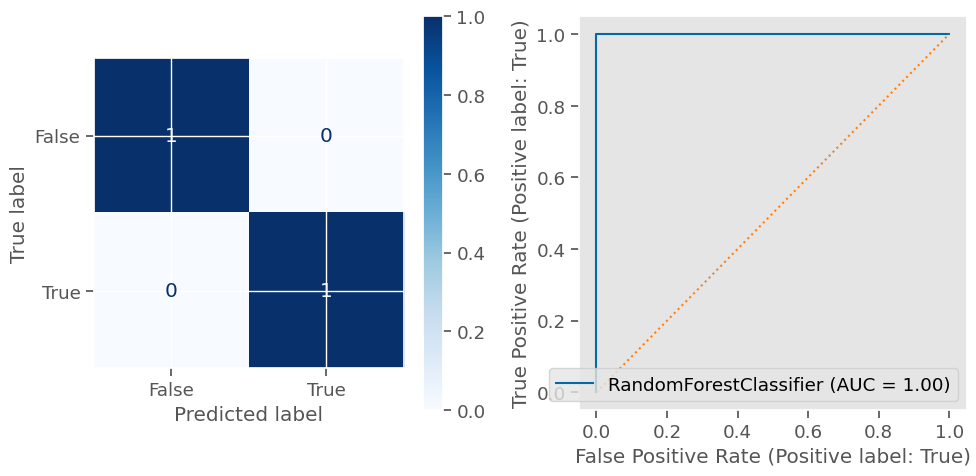

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

       False       0.81      0.70      0.75        71
        True       0.79      0.87      0.83        92

    accuracy                           0.80       163
   macro avg       0.80      0.79      0.79       163
weighted avg       0.80      0.80      0.80       163



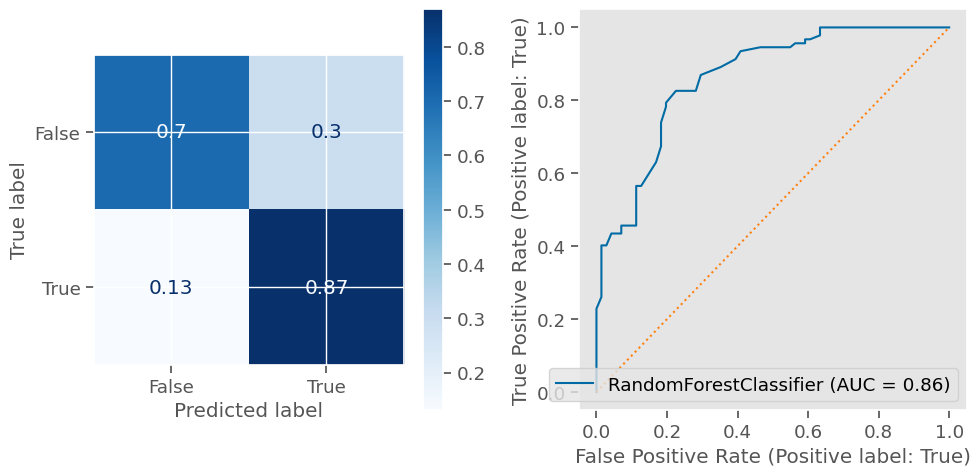

In [24]:
## fit random forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()#class_weight='balanced')
rf_clf.fit(X_train_df,y_train)
evaluate_classification(rf_clf,X_train_df,y_train, X_test_df,y_test)



We have an overall accuracy of .80, which isn't bad. However, our task is to identify the students who will get an F (the True group). So let's take a closer look at our True class scores.

The Recall score for True is .87. This means that out of all of the students who will fail, our model is identifying 87% of them correctly. While this isn't perfect (there are still 13% of students who will fail that are falling through the cracks), this is MUCH better than our R-squared of 0.35!

As we can see above, our classification task is performing much better than our regression version of the task! This is a much more appropriate model to extract insights from.

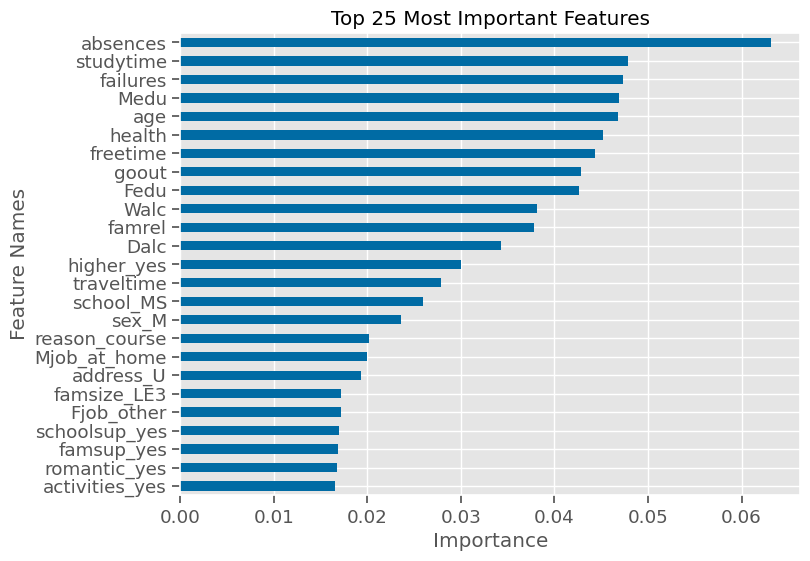

In [31]:
rf_importances = get_importances(rf_clf)
ax = plot_importance(rf_importances,top_n=25)



As we can see above, absences, studytime, failures, Medu, and age are the most important features, with many other features not too far behind.

As we discussed previously, built-in feature importances are biased towards considering numeric features as more important, so let's compare these importances to our Permutation Importance

## Permutation Importances - RandomForest

In [32]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rf_clf,X_train_df,y_train,n_jobs=-1,n_repeats=5)
r.keys()



dict_keys(['importances_mean', 'importances_std', 'importances'])

In [33]:
## getting the colors for the top 7 important rf features
colors_rf = get_color_dict(rf_importances,top_n=7)



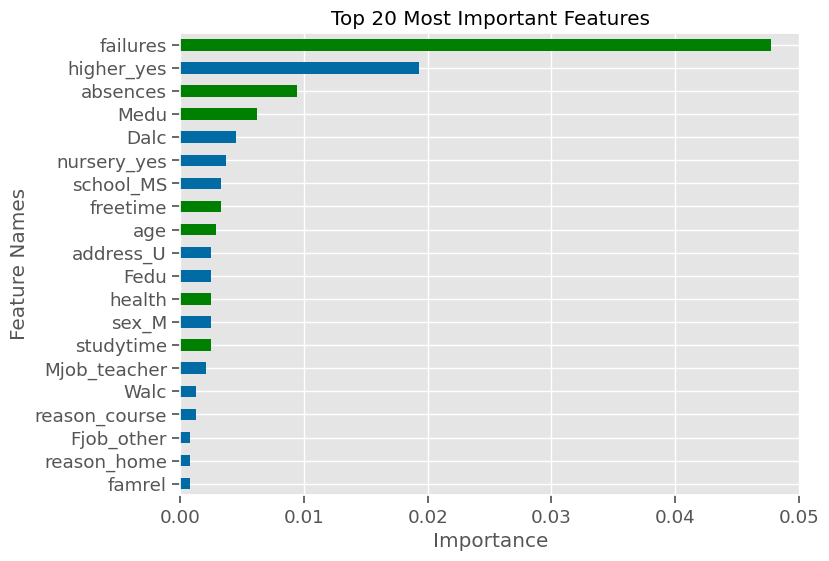

In [40]:
## can make the mean importances into a series
rf_perm_importances = pd.Series(r['importances_mean'],index=X_train_df.columns,
                           name = 'permutation importance')
rf_perm_importances = rf_perm_importances.sort_values(ascending=False)
plot_importance_color_ax(rf_perm_importances,color_dict=colors_rf,top_n=20);



As we can see above, one of the features with the top 3 largest permutation importance were not in the random forest's top features:

higher_yes

As we previously discussed, built-in feature importance often overlooks categorical features. Our permutation importance, however, avoids this bias and it determined 1 out of the 3 most important features to be a categorical feature.

Also, as we discussed previously, neither feature importance nor permutation importance tells us the directionality of that feature vs the target.

higher_yes means that the student is planning to pursue higher education. We may suspect that being in this group leads to decreased likelihood of Failing, but we cannot say that for sure with just this information.

## Post-Modeling EDA

Let's combine all of our processed data back into 1 DataFrame for our final EDA.

This means we want to combine:
    
X_train and y_train (first),

X_test and y_test (second),

and then combine both of the above!

In [41]:
# Combining all data for eda post-modeling
plot_df_train = pd.concat([X_train_df, y_train],axis=1)
plot_df_test = pd.concat([X_test_df, y_test],axis=1)
plot_df = pd.concat([plot_df_train, plot_df_test])
plot_df



,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,target_F
54,15.0,3.0,3.0,1.0,1.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,False
208,16.0,2.0,3.0,2.0,1.0,0.0,5.0,3.0,3.0,1.0,1.0,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,True
23,16.0,2.0,2.0,2.0,2.0,0.0,5.0,4.0,4.0,2.0,4.0,5.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,True
547,16.0,4.0,1.0,1.0,1.0,0.0,4.0,1.0,2.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,True
604,18.0,1.0,1.0,3.0,2.0,1.0,4.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,17.0,1.0,1.0,1.0,3.0,0.0,4.0,3.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,False
454,16.0,1.0,2.0,1.0,3.0,1.0,1.0,3.0,2.0,1.0,2.0,4.0,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,True
56,15.0,4.0,3.0,1.0,2.0,0.0,4.0,3.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,False
203,17.0,1.0,2.0,1.0,2.0,0.0,3.0,1.0,3.0,1.0,5.0,3.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,True


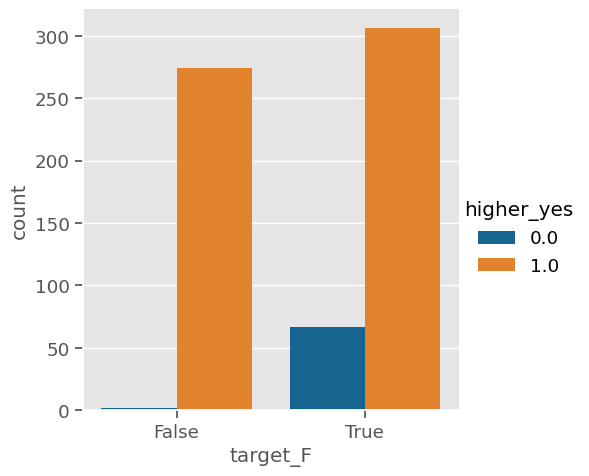

In [42]:
sns.catplot(data=plot_df, kind='count', x='target_F', hue='higher_yes');



As we can see with our EDA above, it looks like there are a higher proportion of students that are NOT pursuing higher education (blue group) in the Failing students (target_F==True) than the successful students.

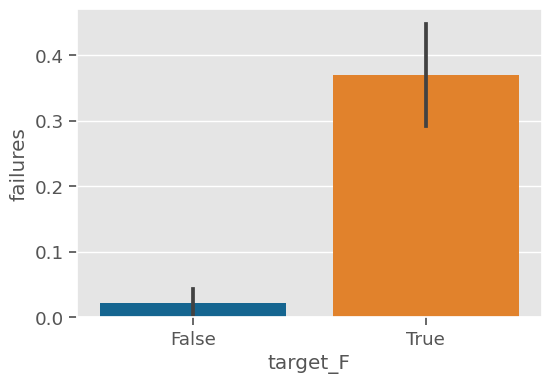

In [43]:
plt.figure(figsize=(6,4))
ax = sns.barplot(data=plot_df, x='target_F',y='failures')



We can see above that students who failed Portuguese had many more failures, on average.

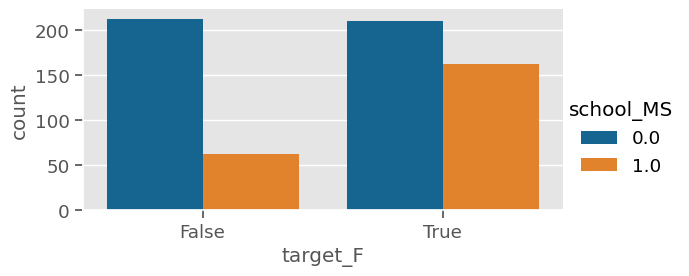

In [44]:
sns.catplot(data=plot_df, kind='count', x='target_F', hue='school_MS',
            aspect=2, height=3);

